**Airbnb Calendar -Time-Series Analysis**

# Introduction



## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [118]:
#Read in libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sklearn

**Read in Data**

In [119]:
#Set path to local machine for data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\03_Processed/'

#Read in Airbnb Calendar listings data
bookings_df = pd.read_csv(path + '2020_0417_Booked_Listings.csv', sep = ',',dtype = {'available' : 'category'},
                       low_memory=True,index_col=0)

#Read in Airbnb Calendar prices data
income_df = pd.read_csv(path + '2020_0417_Daily_Net_Rental_Income.csv', sep = ',',dtype = {'available' : 'category'},
                       low_memory=True,index_col=0)

**Set notebook preferences**

In [120]:
#Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

###Set plot aesthetics for notebook###
#Style
plt.style.use('Solarize_Light2')

#Title dictionary
title_dict = {'fontsize':16,
             'fontweight': 'bold'}
#Label dictionary
label_dict = {'fontsize':12,
             'fontweight': 'bold'}

# Data Overview

## Preview Airbnb Booked Listings Data

In [121]:
#Preview listings data
display(bookings_df.head())

,count
date,
2018-10-03,5897
2018-10-04,5806
2018-10-05,5847
2018-10-06,5822
2018-10-07,5493


## Data Information

In [122]:
#View listings info
bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546 entries, 2018-10-03 to 2020-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   546 non-null    int64
dtypes: int64(1)
memory usage: 8.5+ KB


In [123]:
#Describe listings_df
bookings_df.describe()

,count
count,546.000000
mean,15480.673993
std,6326.237135
min,3978.000000
25%,10409.250000
50%,17639.000000
75%,20689.500000
max,25479.000000


**About the variables**

* date
* available 
* count

## Preview Airbnb Calendar Price Data

In [124]:
#Preview prices data
display(income_df.head())

,net_income
date,
2019-01-09,1322563.0
2019-01-10,1111389.0
2019-01-11,1062798.0
2019-01-12,1060895.0
2019-01-13,1008958.0


## Data Information

In [125]:
#View calendar info
income_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448 entries, 2019-01-09 to 2020-03-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   net_income  448 non-null    float64
dtypes: float64(1)
memory usage: 7.0+ KB


In [126]:
income_df.describe()

,net_income
count,4.480000e+02
mean,3.263110e+06
std,1.312005e+06
min,8.697280e+05
25%,2.045759e+06
50%,3.570038e+06
75%,4.354748e+06
max,5.783902e+06


**About the variables**

* date
* available 
* count

# Time Series Analysis - Bookings Count

## Quick Exploratory Data Analysis

Plot original data

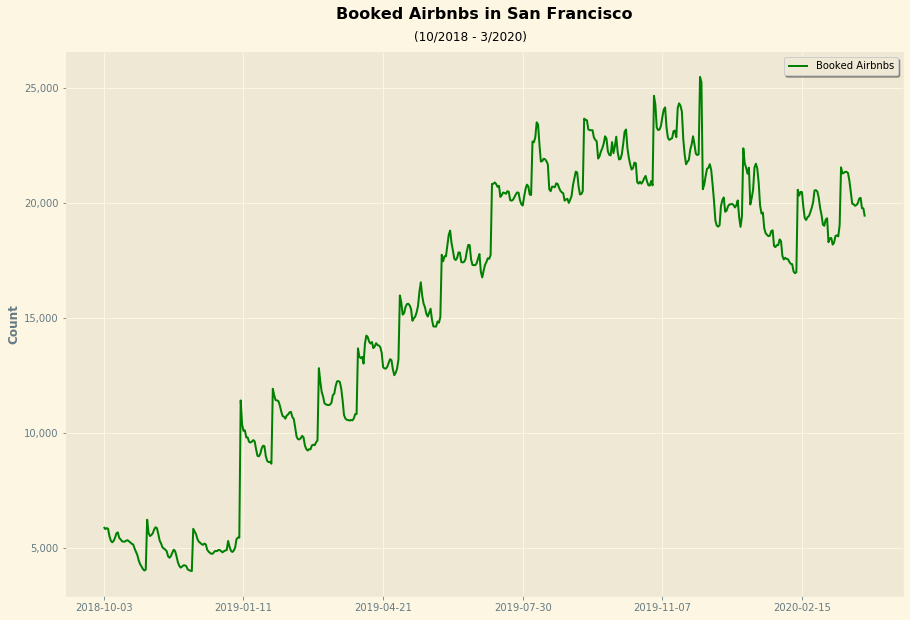

In [127]:
#Set figure size
fig, ax = plt.subplots(figsize = (15,10))
#Visualize airbnbs data
g = bookings_df.plot(y = 'count', ax=ax, color = 'g')

###Set plot Aesthetics###
#Title
ax.set_title('Booked Airbnbs in San Francisco', fontdict = title_dict, y = 1.05)
plt.suptitle('(10/2018 - 3/2020)', y = .91)

#Axes
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Labels
ax.set_ylabel('Count', fontdict = label_dict)
ax.set_xlabel('')

#Legend
ax.legend(labels = ['Booked Airbnbs'],frameon = True, shadow = True)

## Decompose Original Data

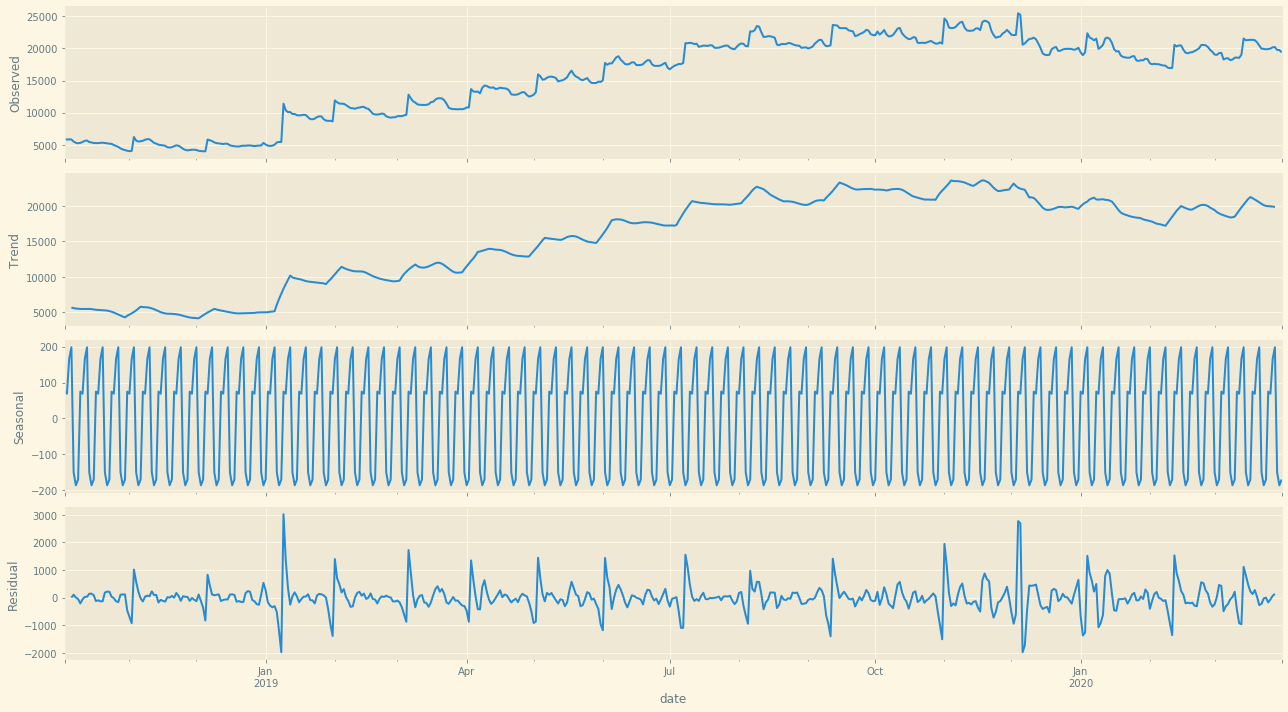

In [128]:
#Convert index to DateTimeIndex
bookings_df.reset_index(inplace=True)
bookings_df.date = pd.to_datetime(bookings_df.date)
bookings_df.set_index('date', inplace=True)

#Read in seasonal decompose model
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 18, 10

#Fit seasonal_decompose to airbnb data
result = seasonal_decompose(bookings_df, model='additive')

#Plot
result.plot();

## Prep Data

### Removing Non-Stationarity

#### Detrend Data

**Prepare Data**

In [129]:
#Apply seasonal_decompose to count of bookings_df
result_add = seasonal_decompose(bookings_df['count'], model= 'additive',extrapolate_trend='freq')

#Detrend bookings_df['count'] and assign back to bookings_df
bookings_df['detrended'] = bookings_df['count'] - result_add.trend

#Check
display(bookings_df.head())

,count,detrended
date,,
2018-10-03,5897,221.204082
2018-10-04,5806,161.918367
2018-10-05,5847,234.632653
2018-10-06,5822,193.857143
2018-10-07,5493,-48.857143


In [149]:
bookings_df['deseasoned'] = bookings_df['count'] - result_add.seasonal

bookings_df['stationary'] = bookings_df['count'] - result_add.seasonal - result_add.trend

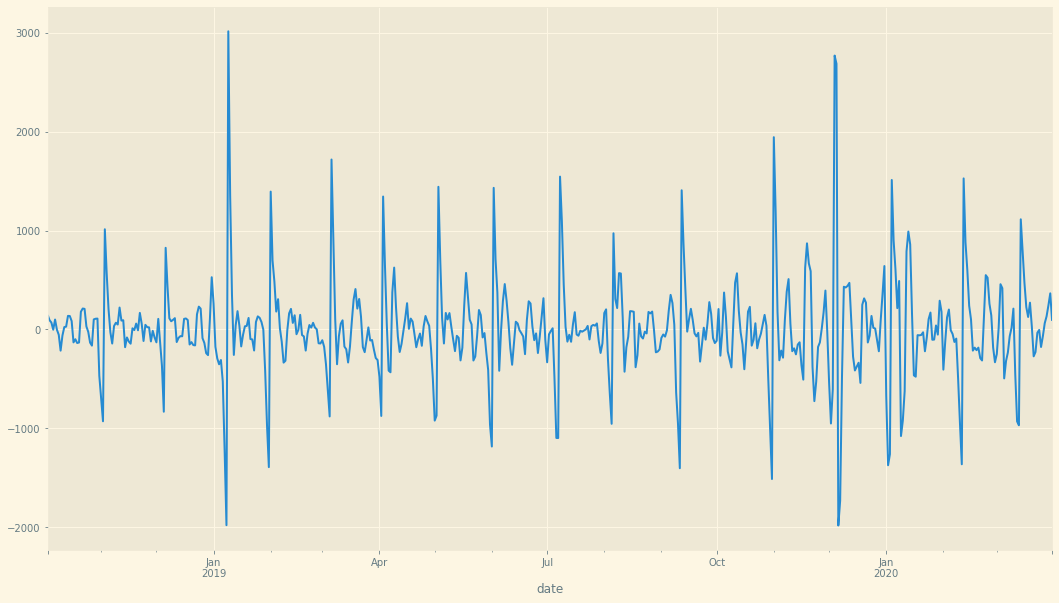

In [151]:
result_add.resid.plot()

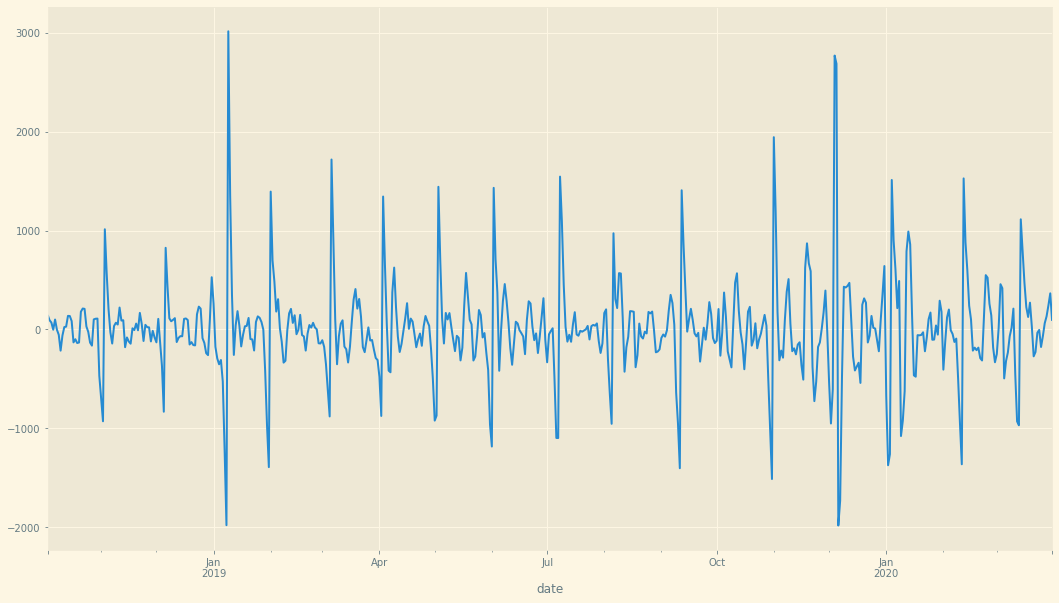

In [150]:
bookings_df.stationary.plot()

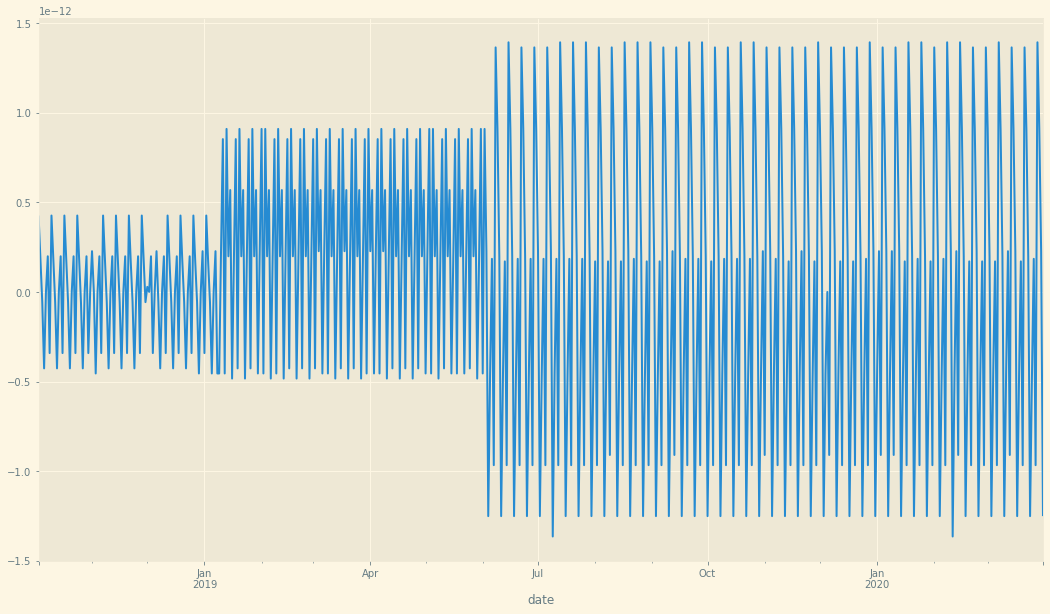

In [153]:
temp = bookings_df

temp.stationary = temp.stationary - result_add.resid

temp.stationary.plot()

**Plot detrended time series**

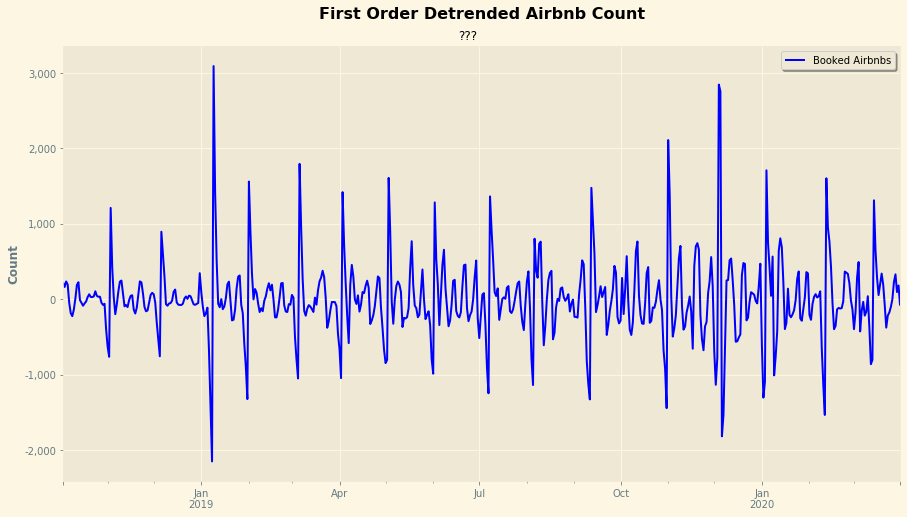

In [130]:
#Set figure
fig, ax = plt.subplots(figsize = (15,8))

#Plot detrended data
g = bookings_df['detrended'].plot(color = 'blue', ax = ax)

###Set plot Aesthetics###
#Title
g.set_title('First Order Detrended Airbnb Count', fontdict = title_dict, y = 1.05)
plt.suptitle('???', y = .91)

#Axes
g.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Labels
g.set_ylabel('Count', fontdict = label_dict)
g.set_xlabel('')

#Legend
g.legend(labels = ['Booked Airbnbs'],frameon = True, shadow = True)

#### Check Seasonality

**Implement KPSS TEST**

In [131]:
#Read in KPSS Test
from statsmodels.tsa.stattools import kpss

#Apply KSS to detrended data
kpss_results = kpss(bookings_df['count'])

#Print results
print('KPSS Statistic: {}'.format(round(kpss_results[0],5)))
print('P-Value: {}'.format(kpss_results[1]))
print('Number of lags: {}'.format(kpss_results[2]))
print('Critical Values:')
for k, v in kpss_results[3].items():
    print('\t{} : {}'.format(k,v))

KPSS Statistic: 2.41368
P-Value: 0.01
Number of lags: 19
Critical Values:
	10% : 0.347
	5% : 0.463
	2.5% : 0.574
	1% : 0.739


C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


**Implement Augmented Dickey-Fuller Test**

In [132]:
#Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

#Implement on detrended timeseries
result  = adfuller(bookings_df['count'])

#Print results
print('ADF Statistic: {}'.format(round(result[0], 4)))
print('P-Value: {}'.format(result[1]))
print('Critical Values: ')
for k, v in result[4].items():
	print('\t{}:{}'.format(k, v))

ADF Statistic: -1.5031
P-Value: 0.5319832547405526
Critical Values: 
	1%:-3.442495284887805
	5%:-2.86689723299801
	10%:-2.5696232204003677


Determine Seasonality window

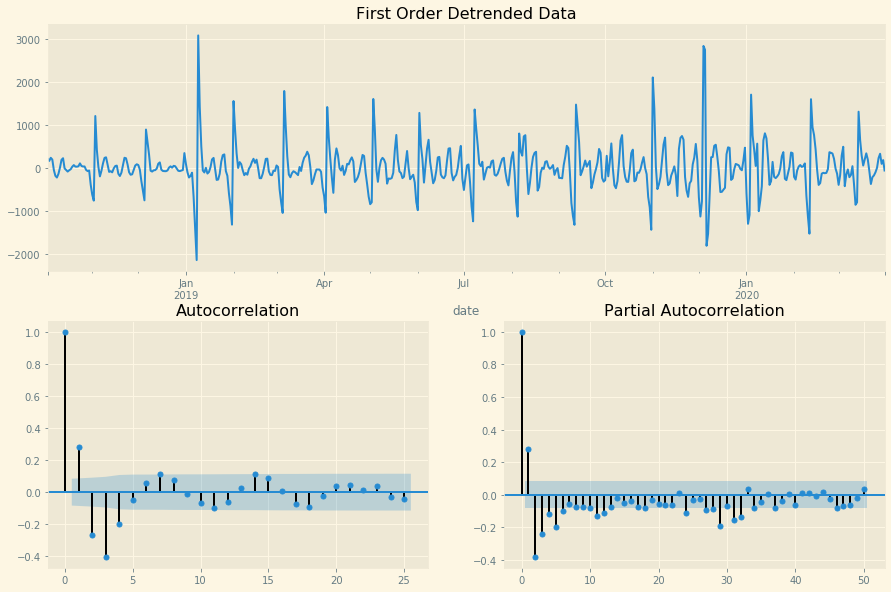

In [133]:
#Import ACF and PACF 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#Create plot
fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)

###RAW DATA#####
#Plot Original Data and associated plot_acf
bookings_df['detrended'].plot(ax=ax1, title = 'First Order Detrended Data')

#Plot acf and pacf
plot_acf(bookings_df['detrended'], lags= 25, ax = ax2);
plot_pacf(bookings_df['detrended'], lags = 50, ax = ax3);

### Apply models for forcasting

**Split data**

In [134]:
#Set cutoff for 90:10 split
cutoff = round(len(bookings_df)*.90)

#Split Data
train = bookings_df['count'][:cutoff]
test = bookings_df['count'][cutoff:]

#Check shape
print('Training data shape:', train.shape)
print('Test data shape:', test.shape)

Training data shape: (491,)
Test data shape: (55,)


Metrics

In [135]:
def metrics(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print('MSE: {}\nRMSE: {}\nMAE: {}'.format(mse,rmse,mae))

**Forecasting with Holt-Winters model**

In [136]:
#Read in Holt-Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing


#Turn off dampening
hw_model = ExponentialSmoothing(train, trend = 'additive', seasonal='additive', 
                               seasonal_periods= 7 , damped=False, )

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [137]:
test.shape

(55,)

In [138]:
#Make forecasts
fit = hw_model.fit()
pred = fit.forecast(55)

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Plot

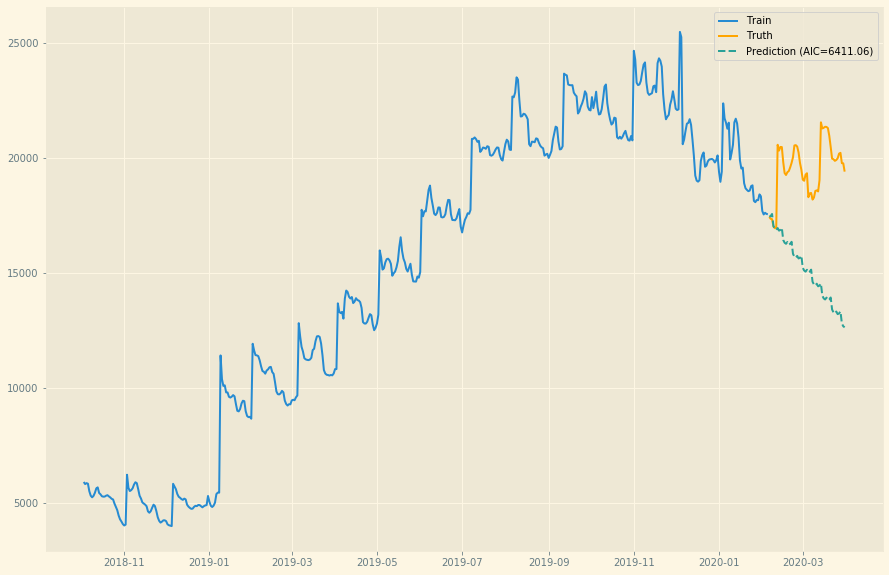

In [144]:
#set figure
fig, ax = plt.subplots(figsize = (15,10))

#
ax.plot(train.index, train.values, label = 'Train', )
ax.plot(test.index, test.values, label = 'Truth', color = 'orange')
ax.plot(test.index, pred.values, linestyle = '--',label="Prediction (AIC={:0.2f})".format(fit.aic));


ax.legend()

In [141]:
#Stats hw_model1
print(metrics(pred, test))

MSE: 24366542.96645777
RMSE: 4936.247863150489
MAE: 4445.345556494881
None


**Forecasting with SARIMA**

Finding ARIMA parameters

How much differencing to apply

D = 0, detrended data is already stationary

find the order of the AR term (p) using the Partial Autocorrelation (PACF) plot.


Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

In [57]:
#Import ARIMA
from statsmodels.tsa.arima_model import SA

#Fit  ARIMA(p,d,q)
model = ARIMA(train, order = (3,1,2))
model_fit = model.fit( )

print(model_fit.summary())

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.count   No. Observations:                  436
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -3443.876
Method:                       css-mle   S.D. of innovations            651.661
Date:                Mon, 27 Apr 2020   AIC                           6897.752
Time:                        15:22:03   BIC                           6918.141
Sample:                    10-04-2018   HQIC                          6905.799
                         - 12-13-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            38.6212     12.266      3.149      0.002      14.581      62.662
ar.L1.D.count     0.7793      0.075     10.386      0.000       0.632       0.926
ma.L1.D.count    -0.8222      0.092     

**Plot Residuals**

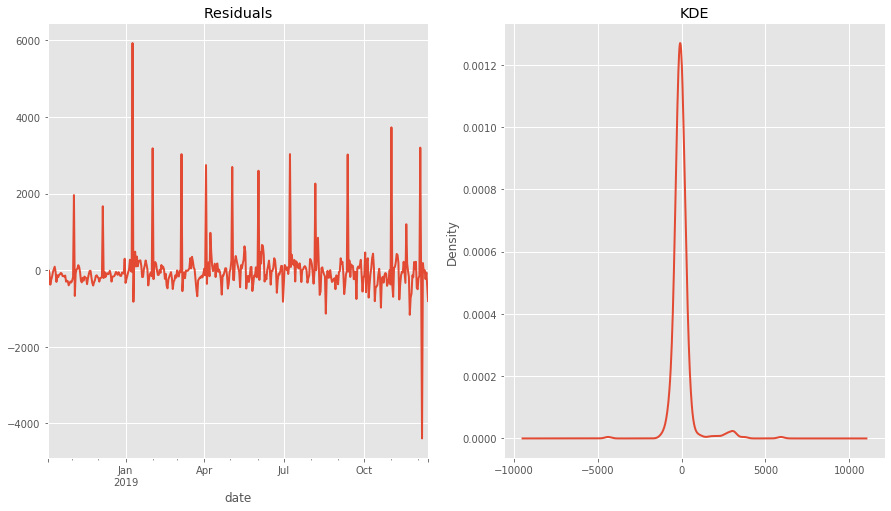

In [58]:
#Set Figure
fig, ax = plt.subplots(1,2, figsize=(15,8))

#Plot residuals
model_fit.resid.plot(title = 'Residuals', ax = ax[0])
model_fit.resid.plot(title = 'KDE',kind = 'kde', ax = ax[1])

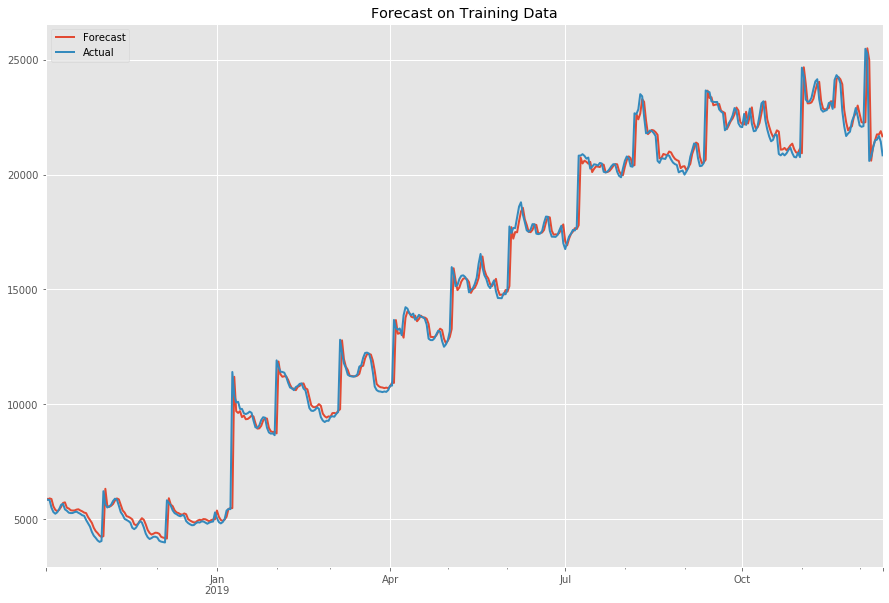

In [59]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,10))
#Set Figure
model_fit.plot_predict(ax=ax);

plt.plot(color = ['r', 'g'])
plt.title('Forecast on Training Data')
plt.legend(labels = ['Forecast', 'Actual'])

Metrics

In [60]:
def metrics(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print('MSE: {}\nRMSE: {}\nMAE: {}'.format(mse,rmse,mae))

In [61]:
metrics(model_fit.predict(),train)

MSE: 253493274.9663807
RMSE: 15921.47213565318
MAE: 14452.951373783064


#Forecast with ARIMA

In [62]:
#Make forecast
fc, se, conf = model_fit.forecast(109, alpha = .05)

#Create Pandas seriesto contain forecast and confidence intervals
fc_series = pd.Series(fc, index = test.index)
lower_conf = pd.Series(conf[:,0], index = test.index) #lower limit of array
upper_conf = pd.Series(conf[:,1], index = test.index) #upper limit of array

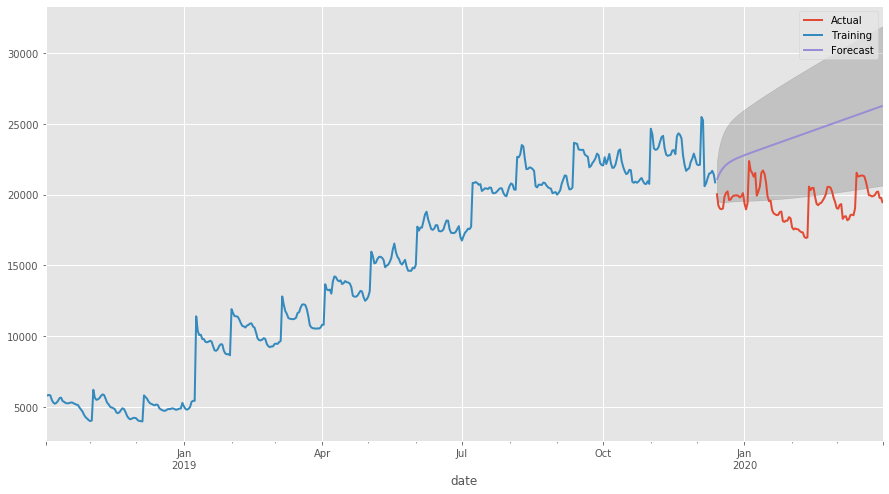

In [63]:
#Set fig size
fig, ax = plt.subplots(figsize = (15,8))

#Plot 
test.plot(label = 'Actual',ax = ax)#
train.plot(label = 'Training', ax=ax)
fc_series.plot(label = 'Forecast', ax = ax)

plt.fill_between(lower_conf.index, lower_conf, upper_conf, 
                 color='k', alpha=.15)

ax.legend()

Metrics

In [53]:
model_fit.predict()

2018-10-04     39.064302
2018-10-05     41.132377
2018-10-06     56.576941
2018-10-07     43.282412
2018-10-08     68.105683
                 ...    
2019-12-09    153.011037
2019-12-10    318.123828
2019-12-11    152.384854
2019-12-12    241.342291
2019-12-13    160.348321
Freq: D, Length: 436, dtype: float64

### Reducing Noise with smoothing

**Prep data: Apply rolling average and LOESS(Localized Regression) Smoothing to detrended data**

In [35]:
# #Read in LOESS
# from statsmodels.nonparametric.smoothers_lowess import lowess

# #5% smoothing
# detrended_loess_5 = pd.DataFrame(lowess(bookings_df.detrended.values, np.arange(len(bookings_df.detrended.values)), frac=.05)[:,1], 
#                                  index=bookings_df.index, columns=['smoothed_value'])

# #15% smoothing
# detrended_loess_15= pd.DataFrame(lowess(bookings_df.detrended.values, np.arange(len(bookings_df.detrended.values)),frac=.15)[:,1], 
#                                  index= bookings_df.index, columns=['smoothed_values'])



**Plot Data**

In [36]:
# #Create figure
# fig, ax = plt.subplots(4, 1, figsize = (15,15))

# #Plot Data
# bookings_df.detrended.plot(color = 'black', ax = ax[0]) #original detrended data

# detrended_loess_5.plot(ax = ax[1])

# detrended_loess_15.plot(ax = ax[2])

# ##weekly avg
# smooth_detrended = bookings_df.detrended.rolling(7, min_periods = 5).mean()
# smooth_detrended.plot(ax = ax[3])


In [54]:
len(model_fit.forecast(109, ))

3

In [ ]:
test.shape

**Auto ARIMA**

In [ ]:

import pmdarima as pm

#Init ARIMA model
arima_model = pm.auto_arima(train,start_p=1, start_q=1,
                           test = 'adf',
                           max_p=5, max_q=5,
                           seasonal=False, d = None,
                            n_jobs=-1, start_P = 0, trace=True,
                            error_action='ignore', suppress_warnings=True)

In [ ]:
print(arima_model.summary())

In [ ]:
arima_model.plot_diagnostics();

Implement Prophet Model

In [ ]:
#Read in libraries
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.diagnostics import cross_validation

Prep Training Data

In [190]:
#Reset index of training data
train_prophet = train.reset_index()

#Rename columns
train_prophet.columns = ['ds', 'y']

#Check
train_prophet.head()

,ds,y
0,2018-10-03,221.204082
1,2018-10-04,161.918367
2,2018-10-05,234.632653
3,2018-10-06,193.857143
4,2018-10-07,-48.857143


In [191]:
test.shape

(109,)

In [195]:
#Init prophet
prophet = Prophet()

#Fit to train data
prophet.fit(train_prophet, )

#Create future dates that prophet will predict 90 days into the future
future = prophet.make_future_dataframe(90, freq = 'D')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecast with prophet

In [197]:
#Make predictions
forecast = prophet.predict(future)

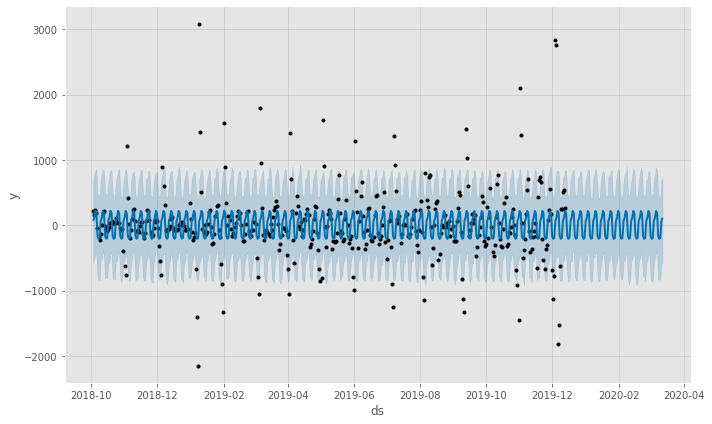

In [211]:
prophet.plot(forecast);

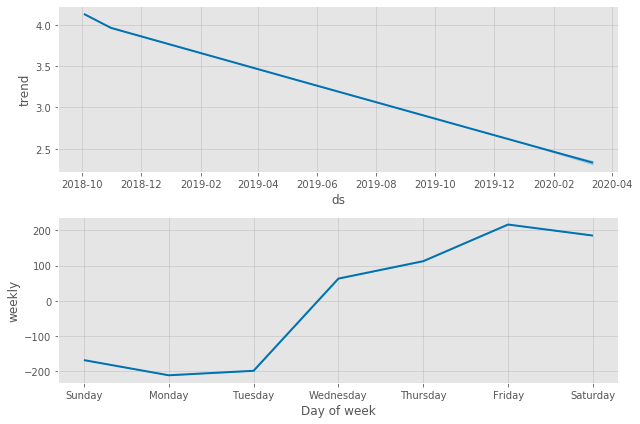

In [213]:
prophet.plot_components(forecast);

In [206]:
#plot

predictions = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(90)

predictions.set_index('ds', inplace = True)

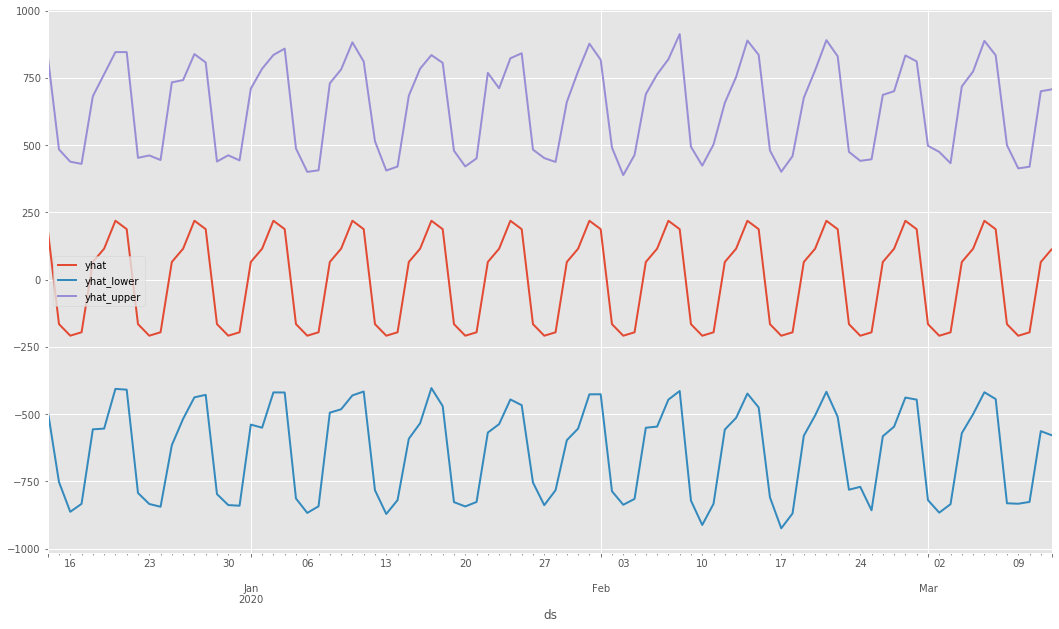

In [207]:
predictions.plot()

# Time Series Analysis - Rental Income

## Quick Exploratory Data Analysis